## Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns # for plot visualization
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# https://www.kaggle.com/amar09/time-series-delhi-weather-forecasting-arima4
# https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

In [2]:
#Reading The dataset
weather_df = pd.read_csv("weather_data_delhi.csv", parse_dates=['datetime_utc'], index_col='datetime_utc')

## Feature Engineering

Keeping only 3 columns "condition", 'humidity', 'temp". It is showing maximum temprature as 90 and max humidity as 243 which is non-realistic, so is an outlier. We need to treat these outliers.

In [3]:
weather_df = weather_df.loc[:,[' _conds', ' _hum', ' _tempm']]
weather_df = weather_df.rename(index=str, columns={' _conds': 'condition', ' _hum': 'humidity', ' _pressurem': 'pressure', ' _tempm': 'temprature'})
weather_df.index = pd.to_datetime(weather_df.index)

weather_df = weather_df[weather_df.temprature < 50]
weather_df = weather_df[weather_df.humidity <= 100]

print(f'dataset shape (rows, columns) - {weather_df.shape}')
print(weather_df.dtypes, weather_df.index.dtype)
print(weather_df.head())

dataset shape (rows, columns) - (100226, 3)
condition      object
humidity      float64
temprature    float64
dtype: object datetime64[ns]
                    condition  humidity  temprature
datetime_utc                                       
1996-11-01 11:00:00     Smoke      27.0        30.0
1996-11-01 12:00:00     Smoke      32.0        28.0
1996-11-01 13:00:00     Smoke      44.0        24.0
1996-11-01 14:00:00     Smoke      41.0        24.0
1996-11-01 16:00:00     Smoke      47.0        23.0


## Data Cleaning
Not many values are missing, but it will still be great to fill the missing ones instead of removing entire row.

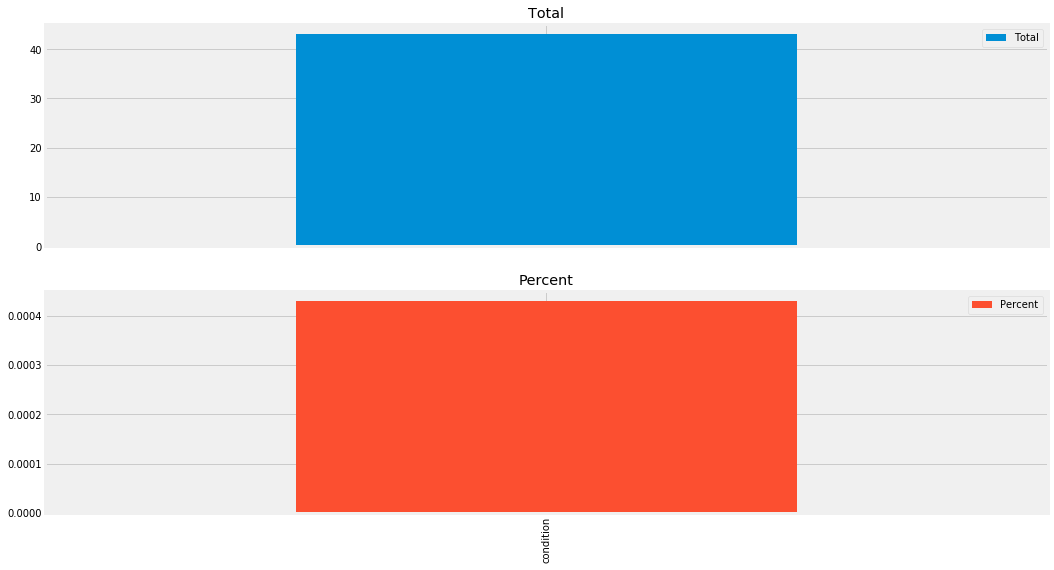

In [4]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    
    missing_data.plot.bar(subplots=True, figsize=(16,9))

list_and_visualize_missing_data(weather_df)

In [5]:
# will fill with previous valid value
weather_df.ffill(inplace=True)
weather_df[weather_df.isnull()].count()

condition     0
humidity      0
temprature    0
dtype: int64

Text(0, 0.5, 'Percent')

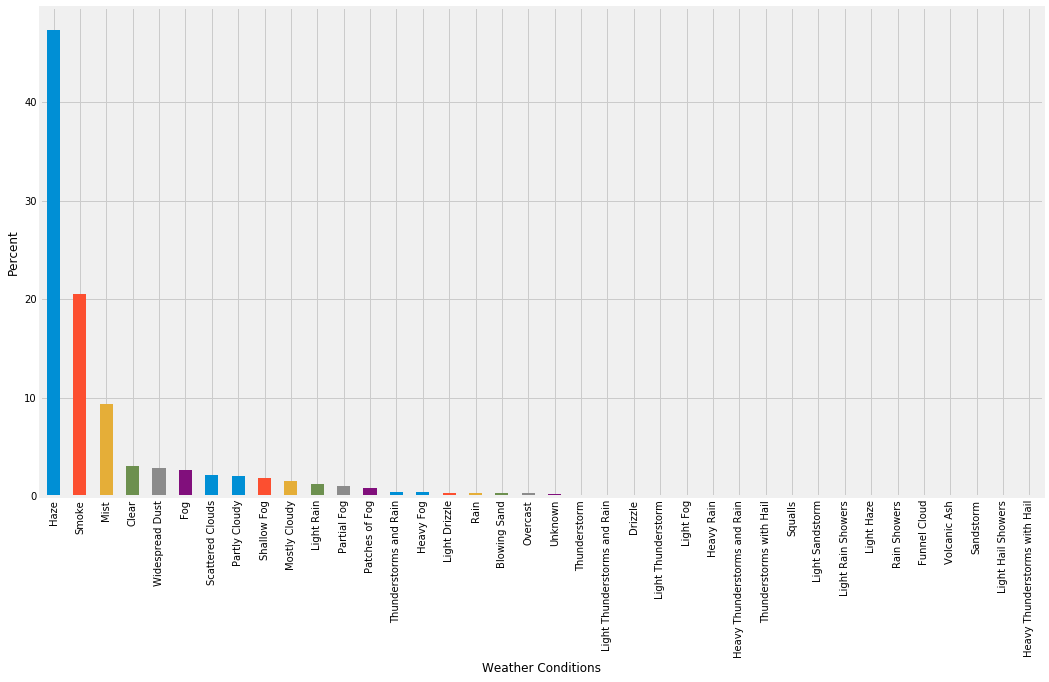

In [6]:
weather_condition = (weather_df.condition.value_counts()/(weather_df.condition.value_counts().sum()))*100
weather_condition.plot.bar(figsize=(16,9))
plt.xlabel('Weather Conditions')
plt.ylabel('Percent')

Oh, it is really bad that mostly Delhi has Hazy and smoky weather conditions, it shows the level of pollution city has.

Let's see how plot for all year's temprature and humidity looks like

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002120E0E7C50>,
      dtype=object)

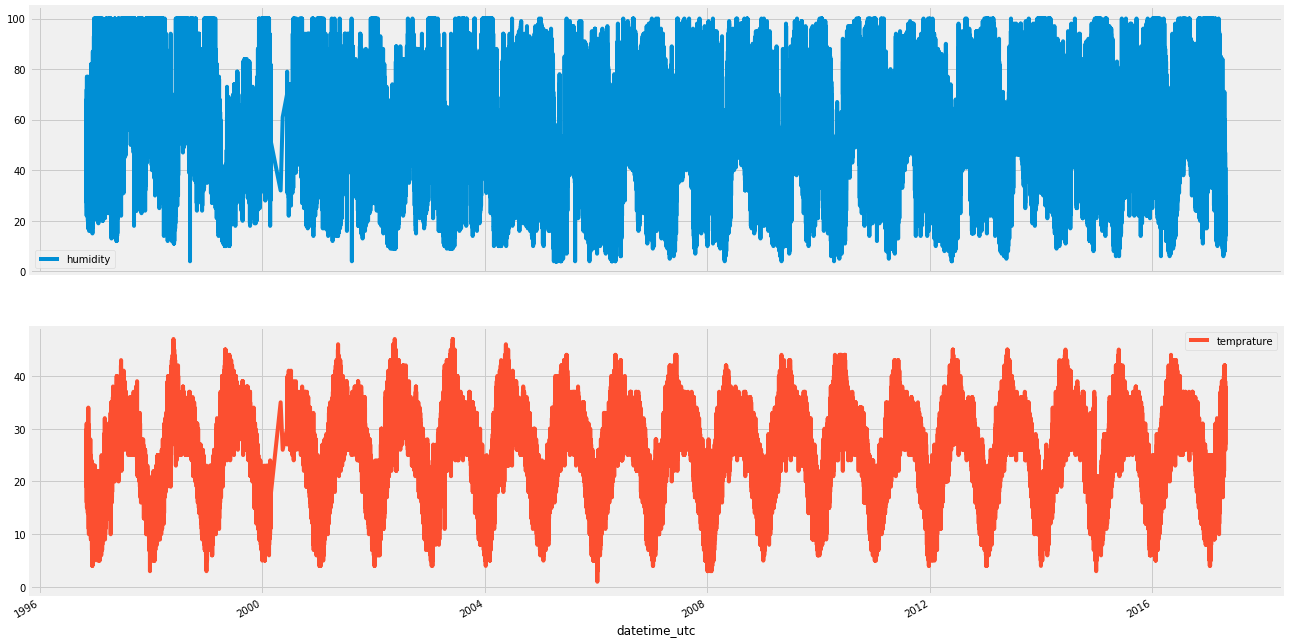

In [7]:
weather_df.plot(subplots=True, figsize=(20,12))

It seems overplotted, let's plot for only two years 2015 and 2016, it will give us the clear picture of seasonality and tread.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002120DFC8EF0>,
      dtype=object)

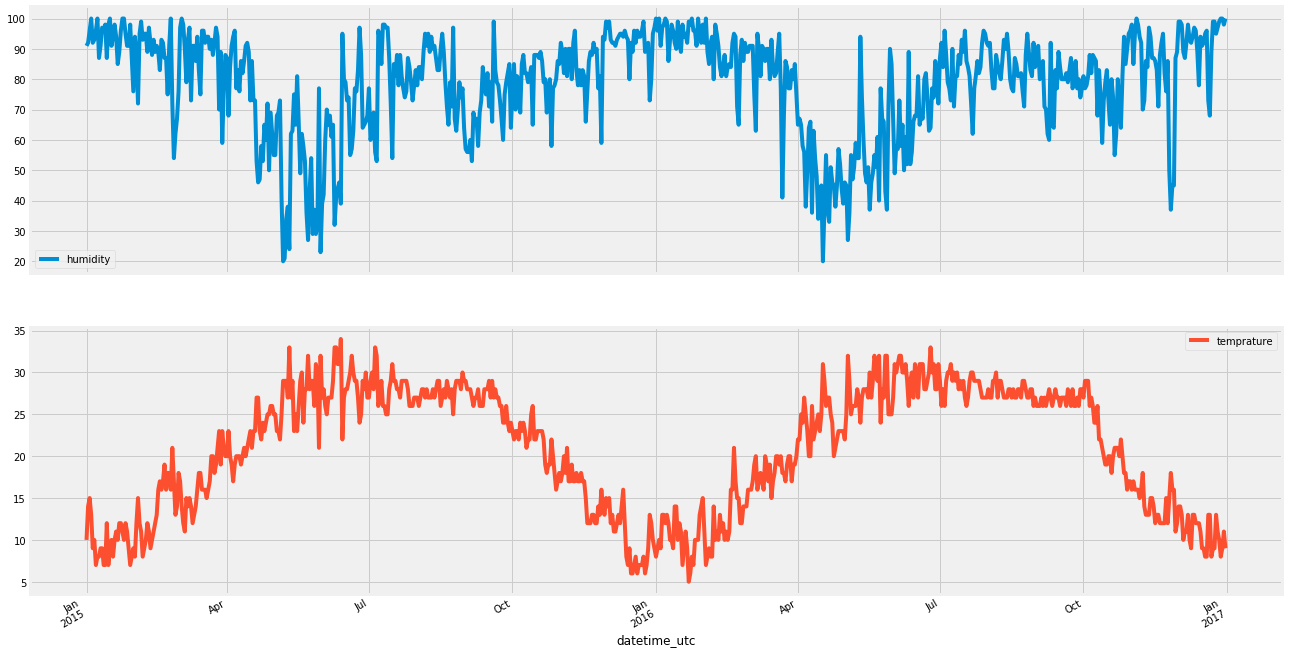

In [8]:
weather_df['2015':'2016'].resample('D').fillna(method='pad').plot(subplots=True, figsize=(20,12))

In [9]:
train_df = weather_df['2015':'2016'].resample('D').mean().fillna(method='pad')
train_df.drop(columns='humidity', axis=1, inplace=True)
test_df = weather_df['2017'].resample('D').mean().fillna(method='pad')
test_df.drop(columns='humidity', axis=1, inplace=True)

Check Stationarity
So above plots shows that we do have seasonality but there is no trend. Let's check for below necessary conditions:

Constant mean
Constant variance
An auto co-variance that does not depend on time

In [10]:
# check rolling mean and rolling standard deviation
def plot_rolling_mean_std(ts):
    rolling_mean = ts.rolling(30).mean()
    rolling_std = ts.rolling(30).std()
    plt.figure(figsize=(22,10))

    plt.plot(ts, label='Actual Mean')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label = 'Rolling Std')
    plt.xlabel("Date")
    plt.ylabel("Mean Temperature")
    plt.title('Rolling Mean & Rolling Standard Deviation')
    plt.legend()
    plt.show()
    
def perform_dickey_fuller_test(ts):
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('Critical Values:' ,result[4])
    

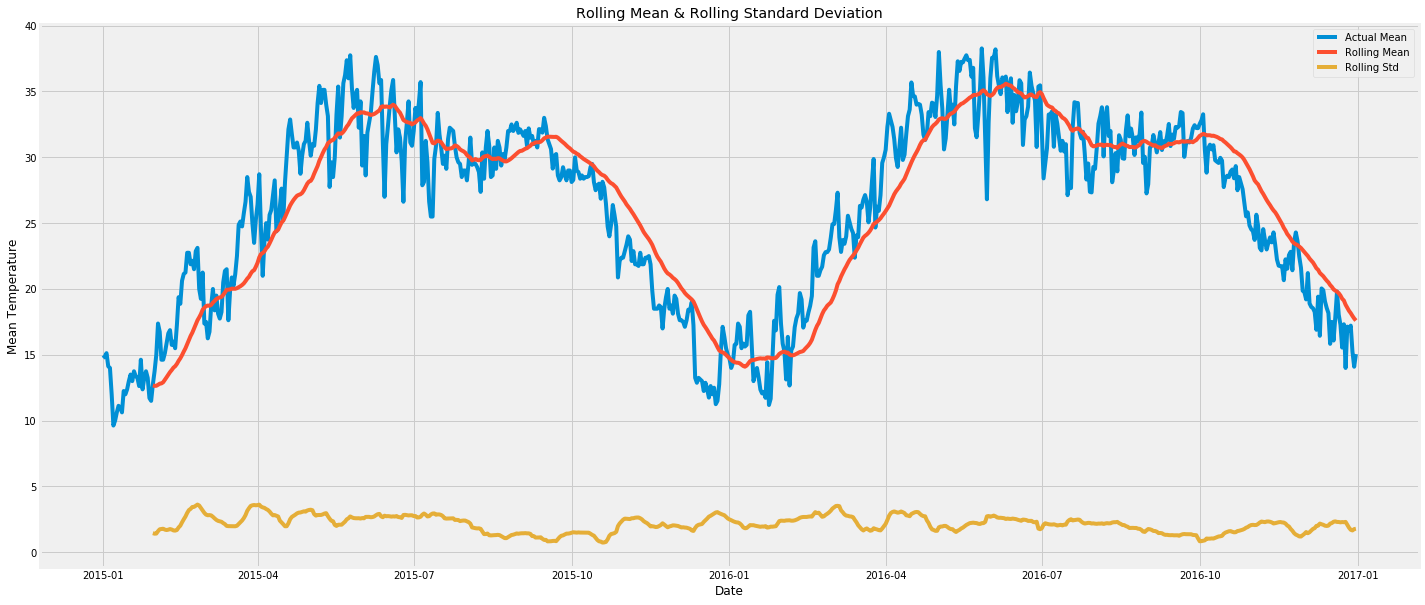

Test statistic:  -1.823070541521873
Critical Values: {'1%': -3.4394522667904153, '5%': -2.8655569894909805, '10%': -2.568909106765338}


In [11]:
# check stationary: mean, variance(std)and adfuller test
plot_rolling_mean_std(train_df.temprature)
perform_dickey_fuller_test(train_df.temprature)

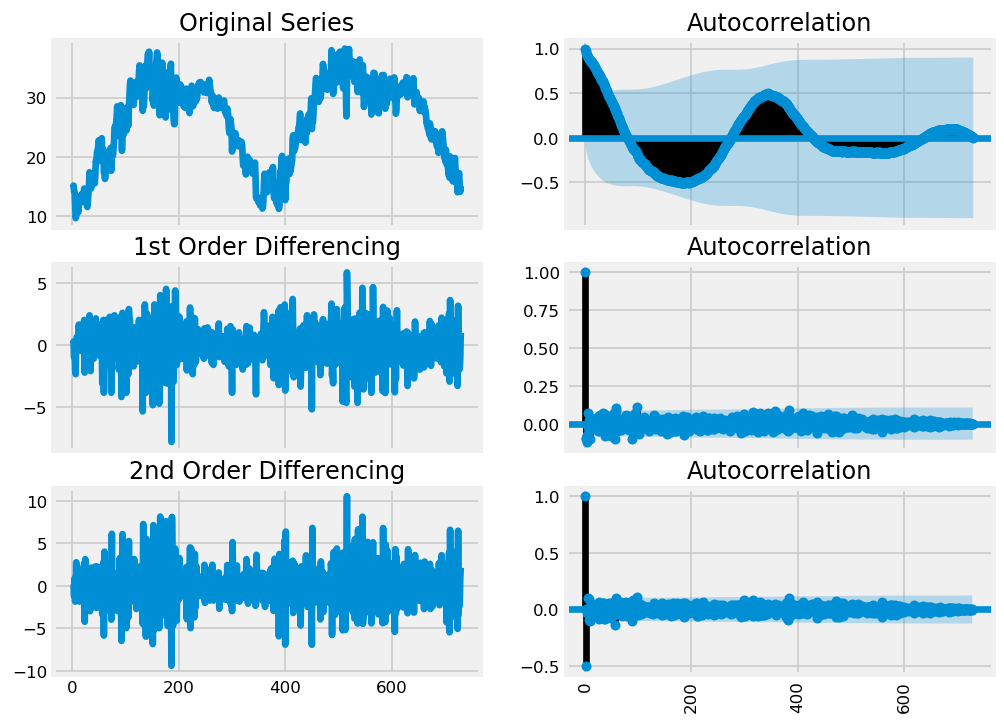

In [12]:
# Original Series
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_df.values); 
axes[0, 0].set_title('Original Series')
plot_acf(train_df.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_df.temprature.diff().values); 
axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_df.diff().dropna().values,ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_df.temprature.diff().diff().values); 
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_df.diff().diff().dropna().values,ax=axes[2, 1])

plt.xticks(rotation='vertical')
plt.show()

C:\Users\amit.bo.gupta\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


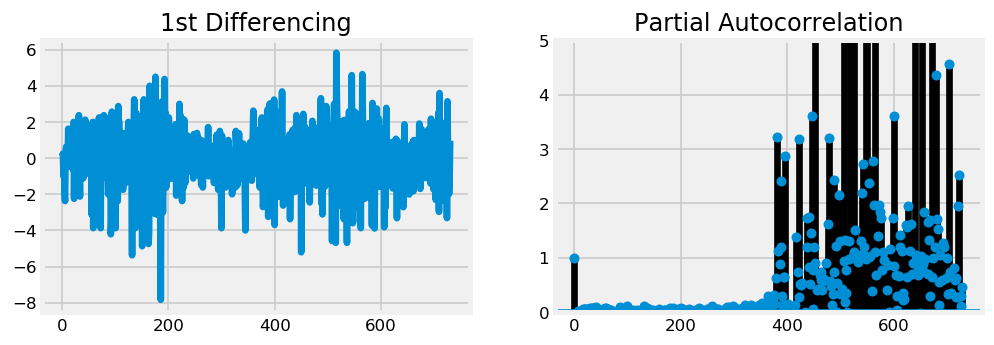

In [13]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

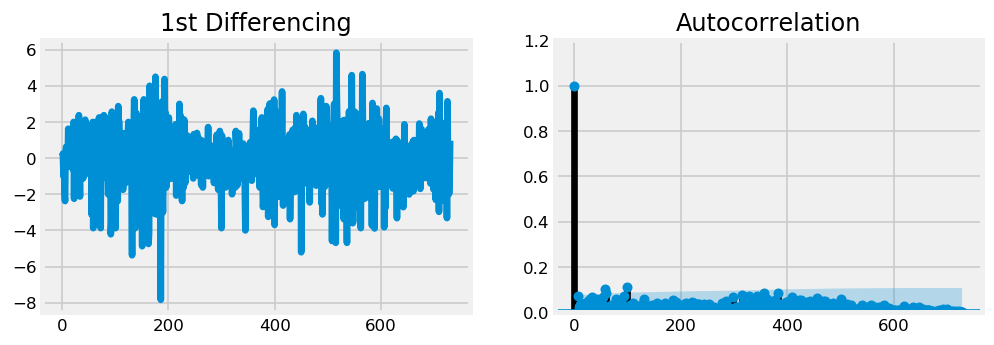

In [14]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_df.diff().values); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train_df.diff().dropna().values, ax=axes[1])

plt.show()

Timeseries Analysis (ARIMA Model)
For prediction we are going to use one of the most popular model for time series, Autoregressive Integrated Moving Average (ARIMA) which is a standard statistical model for time series forecast and analysis. An ARIMA model can be understood by outlining each of its components as follows:

Autoregression (AR) - refers to a model that shows a changing variable that regresses on its own lagged, or prior, values.
The notation AR(p) indicates an autoregressive model of order p.


Integrated (I) - represents the differencing of raw observations to allow for the time series to become stationary, i.e., data values are replaced by the difference between the data values and the previous values.
Moving average (MA) - incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Here instead of difference from previous term, we take errer term (ε) obtained from the difference from past term Now we need to figure out the values of p and q which are parameters of ARIMA model. We use below two methods to figure out these values -

Autocorrelation Function (ACF): It just measures the correlation between two consecutive (lagged version). example at lag 4, ACF will compare series at time instance t1…t2 with series at instance t1–4…t2–4

Partial Autocorrelation Function (PACF): is used to measure the degree of association between X(t) and X(t-p).

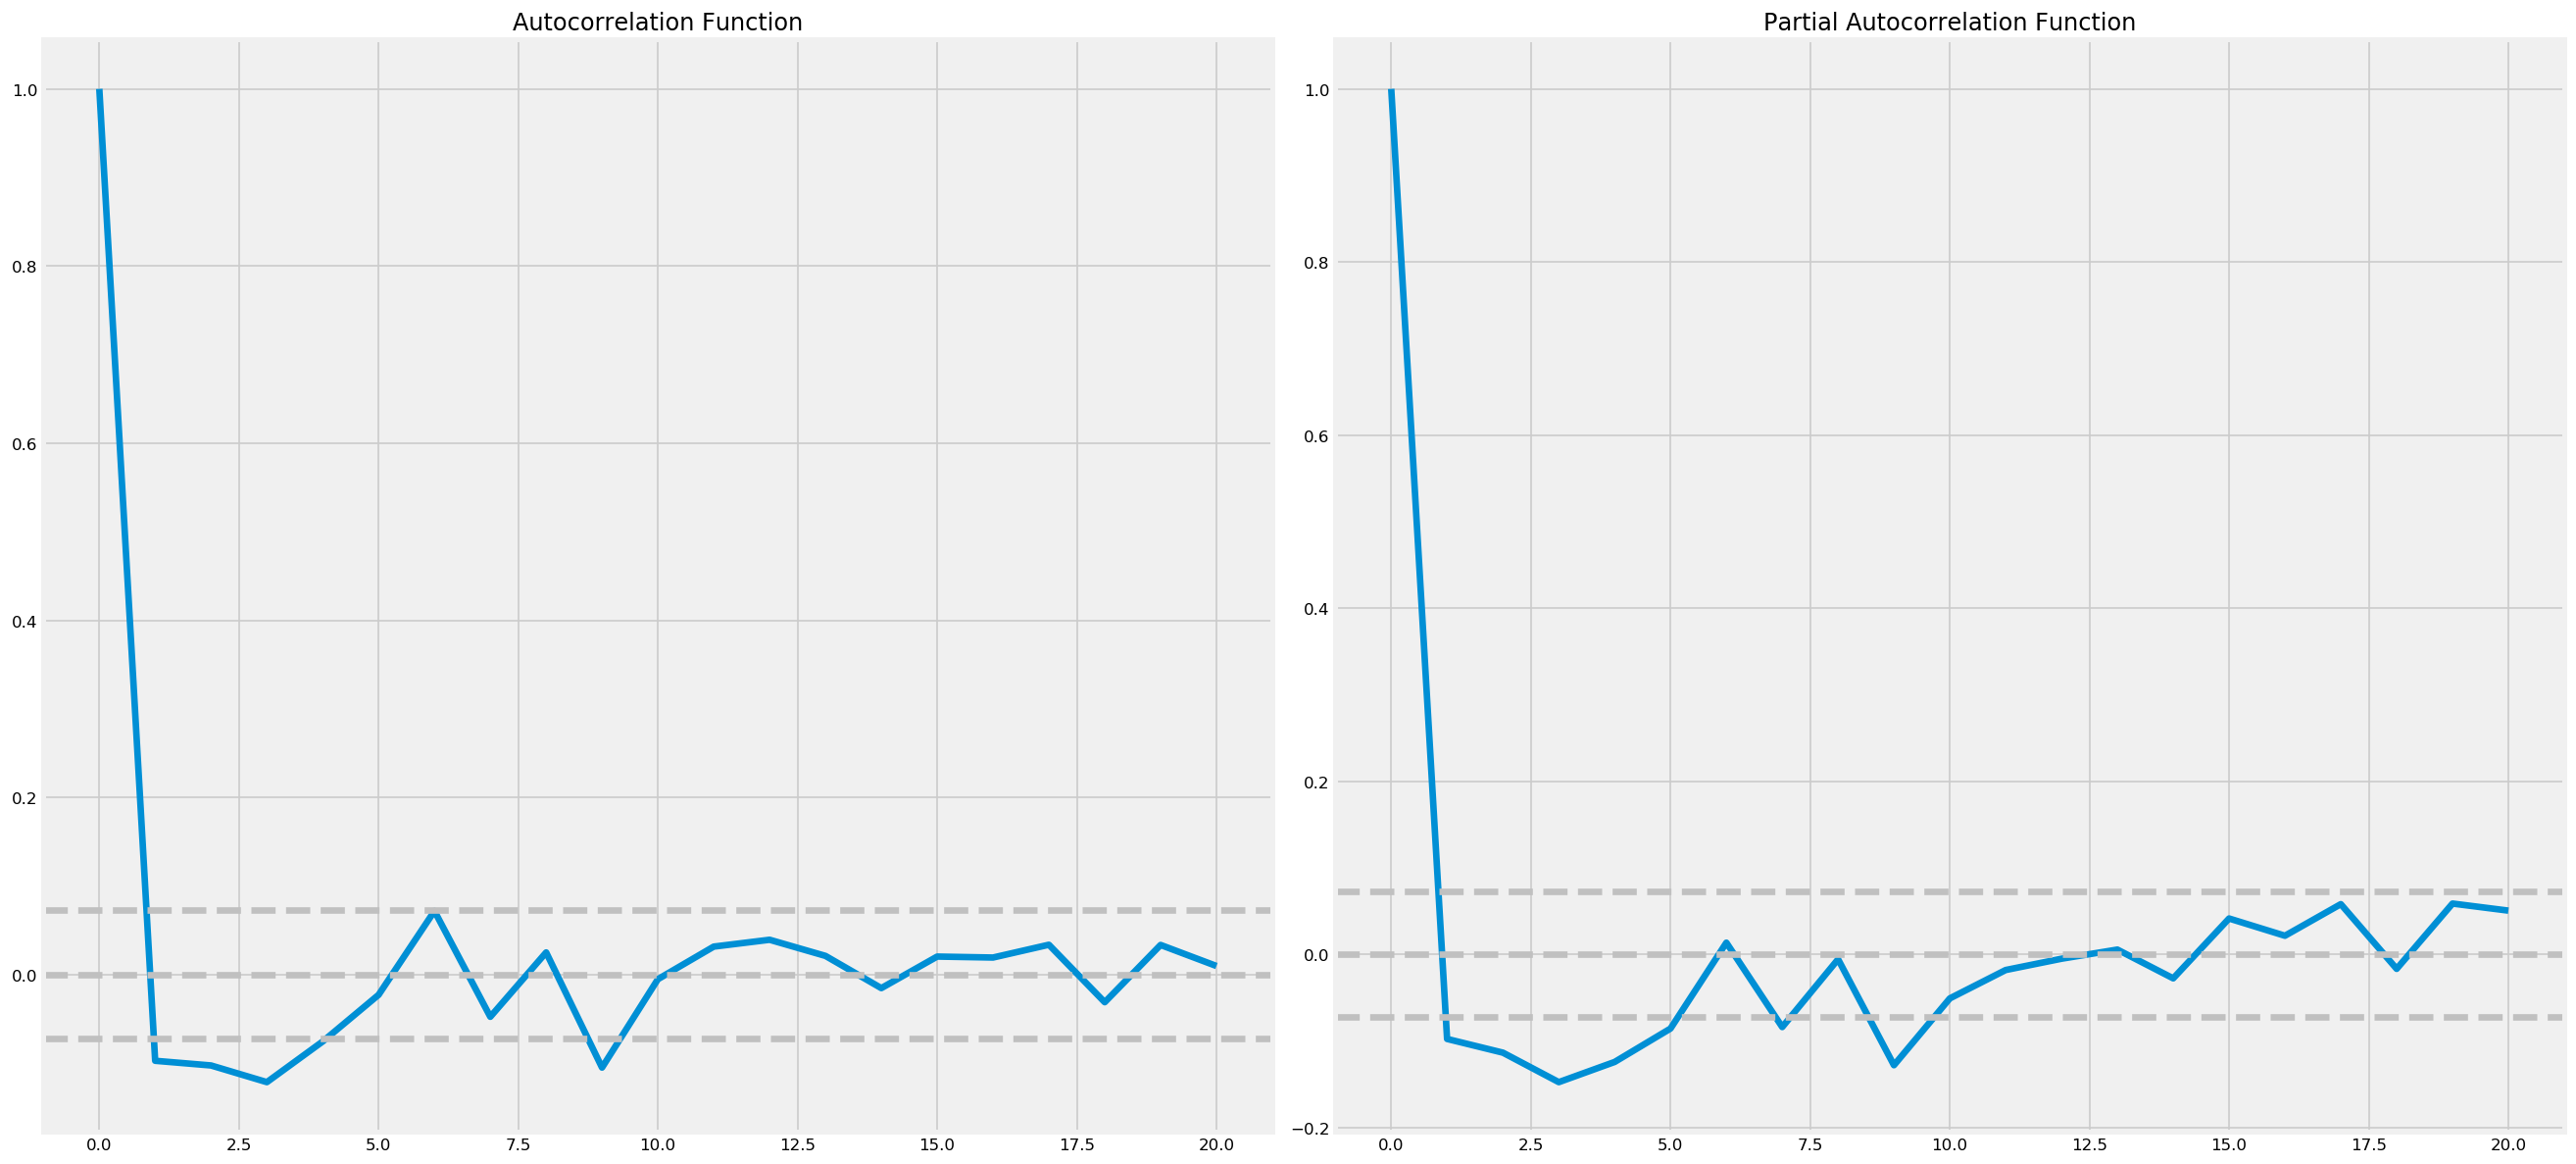

In [15]:
acf_lag = acf(train_df.diff().dropna().values, nlags=20)
pacf_lag = pacf(train_df.diff().dropna().values, nlags=20, method='ols')

plt.figure(figsize=(22,10))

plt.subplot(121)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(122)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(train_df.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function")
plt.tight_layout()

These grey dotted line are confidence intervels which we are going to use to find out the value of p and q.

p - the point where PACF crosses the upper confiednce level. In our case it seems to be 2. So we will take p = 2.

q - the point where ACF crosses the upper confiednce level. In our case it seems to be 2. So we will take q = 2.

d - number of nonseasonal differences needed for stationarity. In this case we are going to take it as 0, since this series is already stationary.

Now we are going fit time series for ARIMA Models. We will compare performance on the basis of RSS score and at last prefer the best one.

In [16]:
model = ARIMA(train_df.values, order=(1,0,1))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  731
Model:                     ARMA(1, 1)   Log Likelihood               -1373.827
Method:                       css-mle   S.D. of innovations              1.581
Date:                Sun, 09 Jun 2019   AIC                           2755.653
Time:                        19:35:38   BIC                           2774.031
Sample:                             0   HQIC                          2762.743
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6208      2.773      8.880      0.000      19.187      30.055
ar.L1.y        0.9823      0.007    135.422      0.000       0.968       0.997
ma.L1.y       -0.1183      0.045     -2.628      0.0

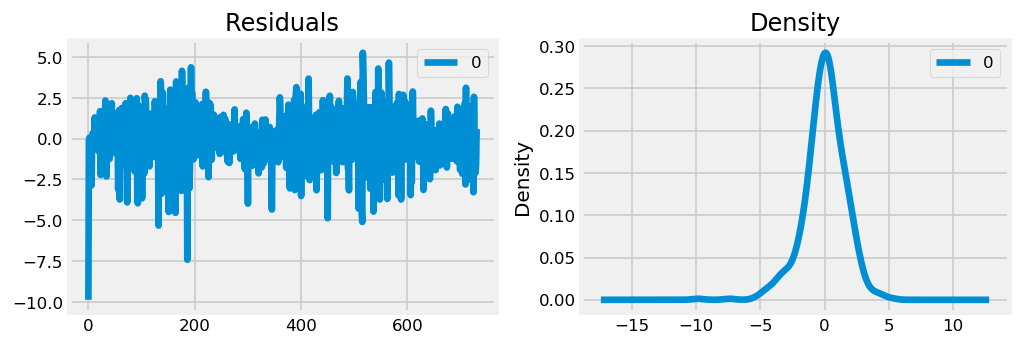

In [17]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

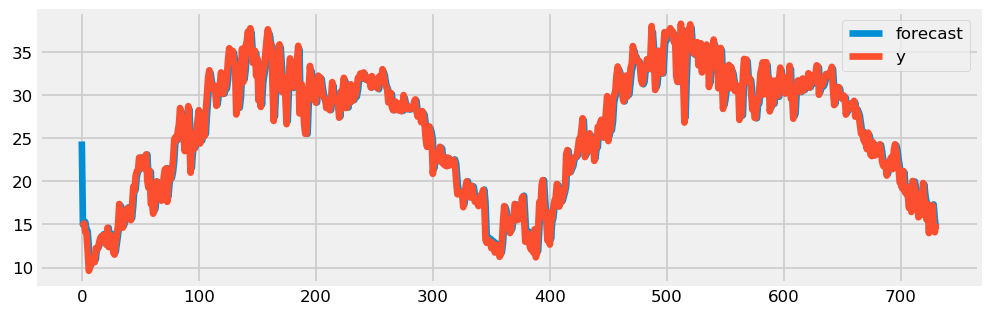

In [18]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

prediction for next 2 weeks datetime_utc
2017-04-11    23.028265
2017-04-12    23.056403
2017-04-13    23.084043
2017-04-14    23.111195
2017-04-15    23.137867
2017-04-16    23.164068
2017-04-17    23.189806
2017-04-18    23.215090
2017-04-19    23.239926
2017-04-20    23.264324
2017-04-21    23.288291
2017-04-22    23.311834
2017-04-23    23.334961
2017-04-24    23.357680
Freq: D, dtype: float64


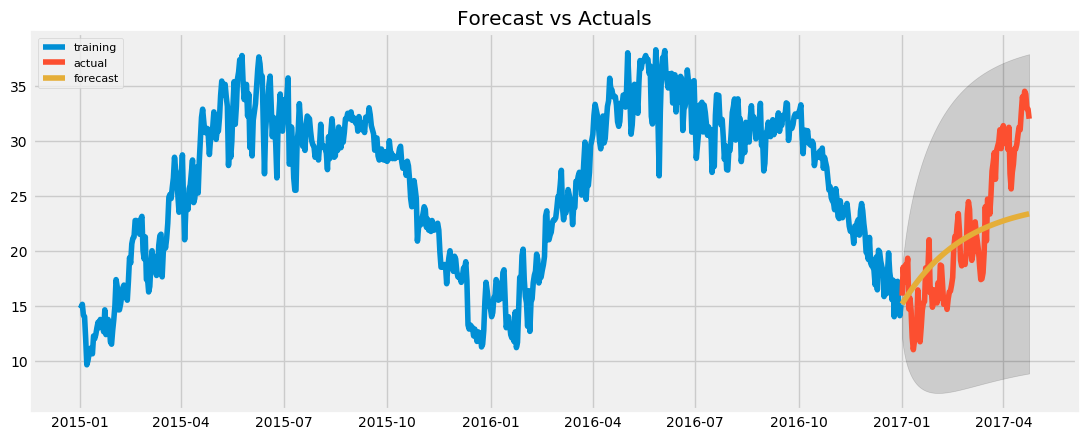

In [19]:
fc, se, conf = model_fit.forecast(114, alpha=0.05)  # 95% conf

# print(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)
print("prediction for next 2 weeks", fc_series.tail(14))
# # Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_df, label='training')
plt.plot(test_df, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()